# Importing Libraries ( will use Tensorflow )

In [175]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os

from PIL import Image

import string

# Extracting Data (train / validation)

In [176]:
df_train = pd.read_csv('../Data/sign_mnist_train.csv')

In [177]:
df_vali = pd.read_csv('../Data/sign_mnist_test.csv')

In [178]:
len(df_train), len(df_vali)

(27455, 7172)

# Splitting

In [179]:
x_train = df_train.drop('label', axis=1).values
y_train = df_train['label'].values

x_vali = df_vali.drop('label', axis=1).values
y_vali = df_vali['label'].values

# Sample

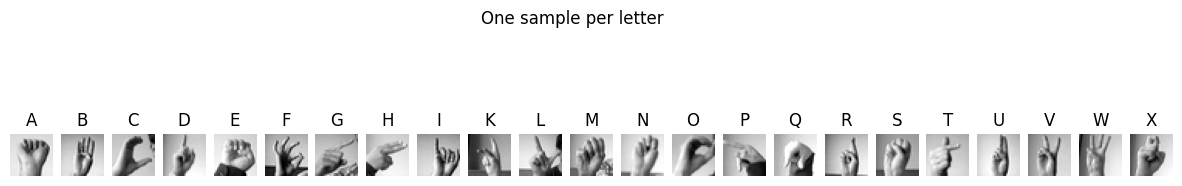

In [180]:

letters = list(string.ascii_uppercase)

mapping = {i: l for i, l in enumerate(letters) if l not in ['J', 'Z']}

plt.figure(figsize=(15, 3))

display_indices = {}
for label_idx in range(len(mapping)):
    idx_train = np.where(y_train == label_idx)[0]
    idx_test = np.where(y_vali == label_idx)[0]

    if len(idx_train) > 0:
        display_indices[label_idx] = ('train', idx_train[0])
    elif len(idx_test) > 0:
        display_indices[label_idx] = ('test', idx_test[0])

for i, label_idx in enumerate(sorted(display_indices.keys())):
    source, idx = display_indices[label_idx]
    if source == 'train':
        img = x_train[idx]
    else:
        img = x_vali[idx]
    plt.subplot(1, len(display_indices), i + 1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(mapping[label_idx])
    plt.axis('off')

plt.suptitle("One sample per letter")
plt.show()

In [181]:
len(x_train), len(y_train), len(x_vali), len(y_vali)

(27455, 27455, 7172, 7172)

# Reshape + Normalization 

In [182]:
x_train.min(), x_train.max(), x_vali.min(), x_vali.max()

(np.int64(0), np.int64(255), np.int64(0), np.int64(255))

In [183]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_vali = x_vali.reshape(-1, 28, 28, 1).astype('float32') / 255.0

In [184]:
x_train.min(), x_train.max(), x_vali.min(), x_vali.max()

(np.float32(0.0), np.float32(1.0), np.float32(0.0), np.float32(1.0))

# Distribution

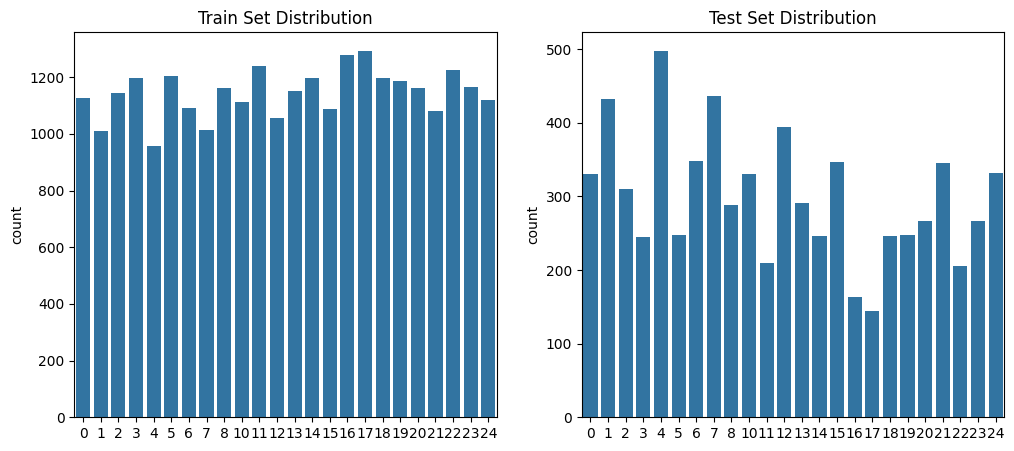

In [185]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Train Set Distribution")

plt.subplot(1,2,2)
sns.countplot(x=y_vali)
plt.title("Test Set Distribution")

plt.show()

# Data Augmentation

In [186]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)

In [187]:
datagen.fit(x_train)

# Model Creation

In [188]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(25, activation='softmax')
])

In [189]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [190]:
cbs = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

# Model Training

In [191]:
history = model.fit(                  
          datagen.flow(x_train, y_train,batch_size=32, shuffle=True),
          epochs=10,
          validation_data=(x_vali, y_vali),
          callbacks=cbs
          )

Epoch 1/10


858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.5331 - loss: 1.6189 - val_accuracy: 0.9317 - val_loss: 0.2261
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9044 - loss: 0.3102 - val_accuracy: 0.9544 - val_loss: 0.1409
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9425 - loss: 0.1813 - val_accuracy: 0.9593 - val_loss: 0.1380
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9535 - loss: 0.1465 - val_accuracy: 0.9621 - val_loss: 0.1456
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9644 - loss: 0.1099 - val_accuracy: 0.9724 - val_loss: 0.1147
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.9686 - loss: 0.0934 - val_accuracy: 0.9622 - val_loss: 0.1267
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - accuracy: 0.9691 - loss: 0.0925 - val_accuracy: 0.9649 - val_loss: 0.1222
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.9738 - loss: 0.0792 - val_accurac

# Accuracy

In [192]:
vali_loss, vali_acc = model.evaluate(x_vali, y_vali)
print("vali accuracy:", vali_acc)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9778 - loss: 0.0760
vali accuracy: 0.9789459109306335


# Classification Report

In [193]:
y_pred = model.predict(x_vali)
y_pred = np.argmax(y_pred, axis=1)

print("classification report: \n", classification_report(y_vali, y_pred))

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       0.93      0.99      0.96       245
           4       0.99      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       0.96      0.93      0.94       348
           7       0.91      0.97      0.94       436
           8       1.00      1.00      1.00       288
          10       1.00      0.99      1.00       331
          11       0.99      1.00      0.99       209
          12       0.99      0.99      0.99       394
          13       0.94      0.99      0.96       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       0.99      1.00      0.99       164
          17   

# Confusion Matrix

In [194]:
Cm= confusion_matrix(y_vali, y_pred)

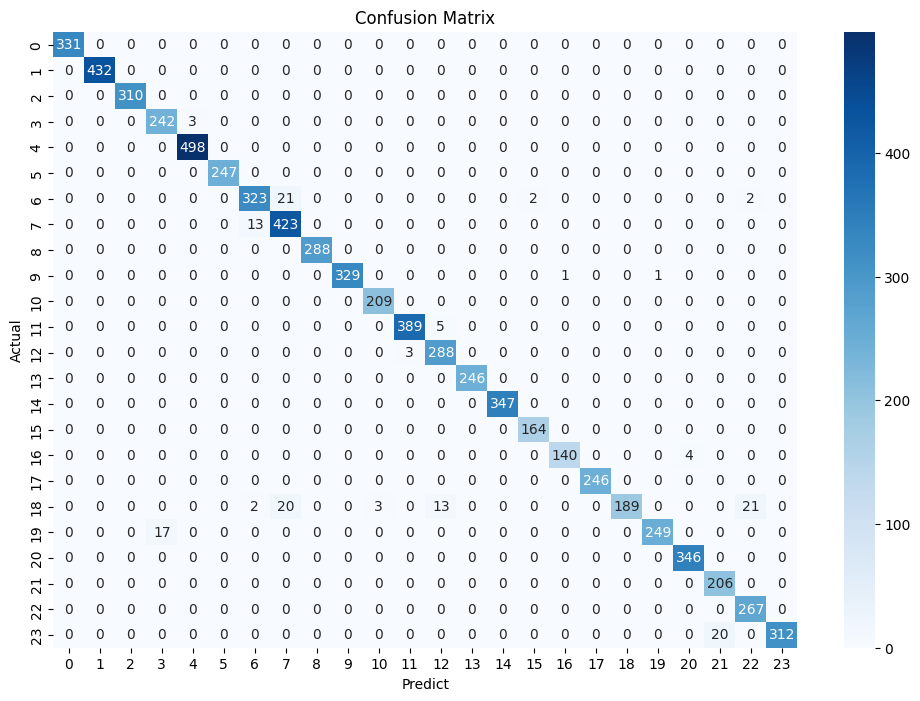

In [195]:
plt.figure(figsize=(12, 8))
sns.heatmap(Cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Samples


In [196]:
predictions = model.predict(x_vali)

predictions = np.argmax(predictions, axis=1)

for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


array([ 6,  5, 11,  0,  3])

In [197]:
correct = np.nonzero(predictions == y_vali)[0]

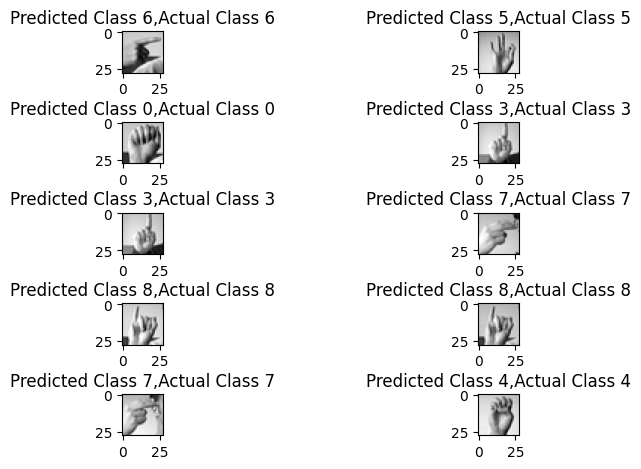

In [198]:
i = 0
for c in correct[:10]:
    plt.subplot(5,2,i+1)
    plt.imshow(x_vali[c].reshape(28,28), cmap="gray")
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_vali[c]))
    plt.tight_layout()
    i += 1
plt.subplots_adjust(hspace=1.2, wspace=0.4) 
plt.show()

# Extracting Image (IGNORE)

In [ ]:
# x_test = df_vali.iloc[:,1:].values.reshape(-1,28,28)
# y_test = df_vali.iloc[:,0].values

In [ ]:
# alphabet = [chr(i) for i in range(ord('A'), ord('Z')+1)]

- Save Images

In [ ]:
# save_path = "../Pictures"

# for i in range(100):
#     img_array = x_test[i] * 255  # scale back
#     img = Image.fromarray(img_array.astype(np.float64), mode="L")
#     img = img.resize((224,224), Image.NEAREST)
#     letter = alphabet[y_test[i]] 
#     img.save(os.path.join(save_path, f"image_{i}_label_{letter}.png"))

# Save Model


In [202]:
path = "../Model/sign_mnist_model.keras"
if os.path.exists(path):
    os.remove(path)
    print("File deleted successfully")
model.save(path)
print("Saved Model")

File deleted successfully
Saved Model
